# Problem Set 7
** James Gong (jhg2141) **

In [1]:
import math
import numpy as np
import kplr
from scipy import integrate
import matplotlib.pyplot as plt

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
f.close()

Next, import my_transit helper function and define func1 and func2, which are the two functions to be integrated to compute the flux theory curve (which is the ratio of the integral(func1)/integral(func2)).

In [2]:
import my_transit

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

# Problem 1

In [3]:
time = hdu_data["time"] # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux

interval = np.where((time > 124) & (time < 125))
time = time[interval]
flux = flux[interval]
flux_err = flux_err[interval]

def two_sigma(flux):
    for i in range(0, 5):
        average = np.mean(flux)
        stdev = np.std(flux)
        exclude = np.where(np.abs(flux - average)/stdev > 2)
        flux = np.delete(flux, exclude) # remove points more than 2-sigma away from mean
    return np.mean(flux)

mean = two_sigma(flux)
flux = flux/mean
flux_err = flux_err/mean

In [4]:
# Guess of parameters
p = 0.0775
tau = 0.1
t_0 = 124.51

def z_t(t, t_0, tau):
    return (t - t_0) / tau

def F_model(t, p, tau, t_0):
    """ gets model f given a time stamp and a p
    calculates z from p and integrates the provided func1 and func2
    """
    z = z_t(t, t_0, tau)
    F = integrate.quad(func1,0,1,args=(p,z))[0] / integrate.quad(func2,0,1,args=(p,z))[0]
    F_err = integrate.quad(func1,0,1,args=(p,z))[1] / integrate.quad(func2,0,1,args=(p,z))[1]
    return F

F = np.array([F_model(t, p, tau, t_0) for t in time])
              
chi2 = np.sum(((flux - F) / flux_err) ** 2)

print "Chi2 value: " + chi2.astype(str)

Chi2 value: 465.1986924205623


# Problem 2

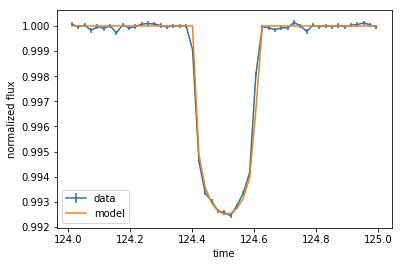

In [5]:
# By eye
plt.errorbar(time, flux, yerr=flux_err, label="data")
plt.errorbar(time, F, label="model")
plt.xlabel("time")
plt.ylabel("normalized flux")
plt.legend()
plt.show()

By eye, the fit looks good.

In [6]:
# By how likely chi2 value is
from scipy import special 
N = len(flux)
M = 3
v = N - M # degrees of freedom
print special.gammaincc(v/2, chi2/2) # p-value

1.098869070516888e-70


This very low p-value indicates that our model parameters are very unlikely.

# Problem 3

In [7]:
chi2_arr = []
taus = np.linspace(0.08, 0.13, 100)
for tau in taus:
    F = np.array([F_model(t, p, tau, t_0) for t in time])
    chi2 = np.sum(((flux - F) / flux_err) ** 2)
    chi2_arr.append(chi2)

best = np.argmin(chi2_arr)
print "Best fit tau value: " + str(taus[best])

Best fit tau value: 0.09666666666666666


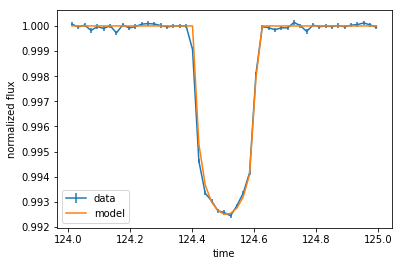

In [8]:
F = np.array([F_model(t, p, taus[best], t_0) for t in time])
chi2 = np.sum(((flux - F) / flux_err) ** 2)

plt.errorbar(time, flux, yerr=flux_err, label="data")
plt.errorbar(time, F, label="model")
plt.xlabel("time")
plt.ylabel("normalized flux")
plt.legend()
plt.show()

In [9]:
print "P-value: " + str(special.gammaincc(v/2, chi2/2))

P-value: 1.2251700286130319e-29


Minimum chi2 value: 248.8250278195545


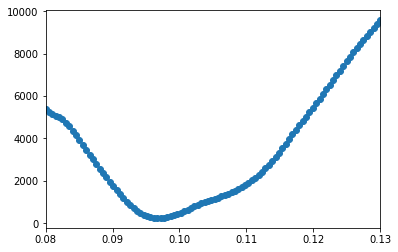

In [10]:
plt.scatter(taus, chi2_arr)
plt.xlim([0.08, 0.13])
print "Minimum chi2 value: " + str(chi2_arr[best])

To determine the one-sigma uncertainty in this parameter, we plot the range of delta-chi around the minimum value of chi2 that corresponds to the 1-sigma uncertainty.

Adding 1 gives a chi2 value of 249.8.

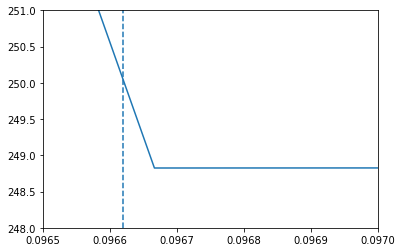

In [11]:
plt.plot(taus, chi2_arr)
plt.axis([0.0965, 0.097, 248, 251])
plt.axvline(x=(0.09662), ls = '--')

So, the corresponding tau value is approximately 0.09662. Thus, the uncertainty is 0.09666666666666666 - 0.09662 = 0.00004666666

# Problem 4

We can use the emcee package to find the best fit parameter set.
Following the example in the emcee documentation, we create log-prior, log-likelihood, and log-probability functions.

In [24]:
def lnprior(theta):
    p,tau,t0 = theta
    
    if p <= 0 or p >= 0.5: # p is the size ratio of the planet to the sttar
        return -np.inf
    elif tau <= 0 or tau >= 1: # tau must also be positive
        return -np.inf
    elif t0 <= 124 or t0 >= 125: # time must be within our time range
        return -np.inf
    return 0

def lnlike(theta, x, y, yerr):
    p, tau, t0 = theta
    model = np.array([F_model(t, p, tau, t0) for t in x])
    
    return np.sum(((y - model) / yerr) ** 2) # for likelihood, we assume the chi-square

def lnprob(theta, x, y, yerr):
    prior = lnprior(theta)
    if np.isfinite(prior):
        return lnlike(theta, x, y, yerr)
    else:
        return prior

In [25]:
import emcee

ndim, nwalkers = 3, 6
initial = [0.0775, 0.1, 124.51] # using the parameter values from the last problem
pos = [initial + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, flux, flux_err))
sampler.run_mcmc(pos, 500)

(array([[  0.49768325,   0.99211516, 124.00000011],
        [  0.49722325,   0.99624109, 124.00000013],
        [  0.49682285,   0.9998442 , 124.00000013],
        [  0.49681076,   0.99989291, 124.00000015],
        [  0.49694516,   0.9987496 , 124.00000013],
        [  0.49695183,   0.99867308, 124.00000015]]),
 array([4.00162395e+08, 4.00223095e+08, 4.00268763e+08, 4.00249620e+08,
        4.00258071e+08, 4.00251723e+08]),
 ('MT19937', array([2191658317, 3231220695,  200617164,  746476625, 3260368042,
          427170445, 1054230495, 1762877700, 1113358592, 1833204747,
         2630136709,  922866495, 1059015381, 2856463462,  685087159,
         3797667858, 1354251137,  446039586, 1596206951, 4110368098,
         1897098451, 4286598957,  111257641, 3585122968, 3065420199,
         1276874445, 2582203336, 3079104751, 1114682842,  465667218,
         2664321994, 3727502875, 4023122603, 1378039526,  536198810,
         4185439629,  755498018,  140022885, 1930620023,  877586150,
         

In [28]:
samples = sampler.chain[:, 400:, :].reshape((-1, ndim)) # uses the last 100
#print samples
best = np.mean(samples, axis=0)
print "Best fit (p, tau, t0): ", best
print "1-sigma uncertainty (p, tau, t0): ", np.std(samples, axis=0)

Best fit (p, tau, t0):  [  0.49909861   0.9795496  124.00000012]
1-sigma uncertainty (p, tau, t0):  [8.27921182e-04 7.37070465e-03 3.28695284e-07]


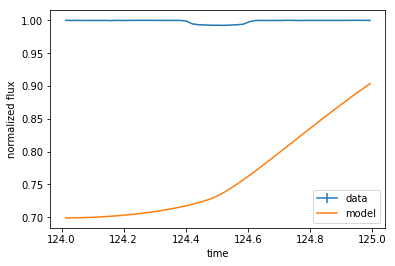

In [32]:
F = np.array([F_model(t, best[0], best[1], best[2]) for t in time])

plt.errorbar(time, flux, yerr=flux_err, label="data")
plt.errorbar(time, F, label="model")
plt.xlabel("time")
plt.ylabel("normalized flux")
plt.legend()
plt.show()

I encountered trouble getting my MCMC to return correct model parameters.